# Demo of `DroneWQ` functions and processing pipeline

In this notebook, we demonstrate the use functions included in DroneWQ package

In [1]:
# you might need these, I'll update the docker image soon!
! pip install GPSphoto geopandas exifread piexif

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 14.7 MB/s eta 0:00:0000:0100:01
  Created wheel for GPSphoto: filename=gpsphoto-2.2.3-py3-none-any.whl size=11880 sha256=01a6e6b432650c5969b24a27539279857c4bc6f45750bb0910cbc20a968005a6
  Stored in directory: /root/.cache/pip/wheels/2a/3a/ea/8aff4448f997d98966ac532c48ff572c53eea439a9d2de6676
Successfully built GPSphoto


TODOs
- update Docker to new config
- need to add-in all the remining processing options
- we should add in a conversion to pandas dataframe at every step for inspection and analysis
- could add a visualization option for a lot of the steps to make sure it is more useful
- add a step by step workflow if we want?

In [1]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
# from georeg import *

/usr/local/envs/micasense/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# this isn't really good practice but there are a few deprecated tools in the Micasense stack so we'll ignore some of these warnings
import warnings
warnings.filterwarnings('ignore')

## Simple processing from raw imagery to corrected Rrs

If you want to just put in your raw Micasense imagery and process it to deglinted, corrected Rrs imagery you can do that with this simple function:

All that you have to do manually is split your data up into this exact structure (name the main_dir whatever you want and put that into the function and keep the rest exactly as named here:
```
    <main_dir>/
        raw_water_imgs/
        align_img/
        raw_sky_imgs/
        panel/
```

With that structure now just specify the path to <main_dir> below:

In [3]:
project_path = os.path.join('data', 'test', 'test_dir')

In [4]:
project_path

'data/test/test_dir'

In [6]:
process_raw_to_rrs(project_path, ed_method='panel', glint_correct=True, glint_std_factor=1.5, sky_reflection_correction='single_lsky')

Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: data/test/test_dir/raw_water_imgs
Loading ImageSet from: data/test/test_dir/align_img
used warp dir data/test/test_dir/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 4
Finished aligning band 1
Finished aligning band 3


/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:20.965832
Alignment+Saving rate: 0.38 images per second
Finished saving images.


    1 directories scanned
    8 image files updated


Finished saving image metadata.
Converting raw sky images to radiance (raw sky -> Lsky).
Loading ImageSet from: data/test/test_dir/raw_sky_imgs
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 2
Finished aligning band 4


/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/Documents/Code/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:04.549427
Alignment+Saving rate: 0.44 images per second
Finished saving images.


    1 directories scanned
    2 image files updated


Finished saving image metadata.


    1 directories scanned
    8 image files updated


Finished Lt glint correction.
Not doing any sky reflection correction.
Normalizing by panel irradiance (Lw -> Rrs).
Loading ImageSet from: data/test/test_dir/panel
All data has been output as Rrs imagery with True glint removal, XXX sky reflection and normalized by XXX irradiance.


    1 directories scanned
    8 image files updated


True

#### Inspect the output from this

It give you back:

1) a list of the images (you can specify how many because they can take up a lot of memory so often loading them all in isn't feasible

2) a dataframe with all the data about the images

you could also just load in the metadata if you want to view it for hundreds or thousands of images with `load_img_fn_and_meta(img_dir)`

In [7]:
lsky_imgs, lsky_img_metadata = retrieve_imgs_and_metadata(project_path+'/sky_lt_imgs', count=10, start=0, altitude_cutoff=0)

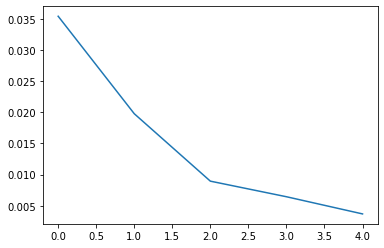

In [10]:
plt.plot(lsky_imgs[0].mean(axis=(1,2)))

In [9]:
lt_imgs, lt_img_metadata = retrieve_imgs_and_metadata(project_path+'/lt_imgs', count=10, start=0, altitude_cutoff=0)

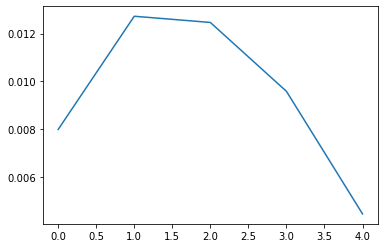

In [11]:
plt.plot(lt_imgs[0].mean(axis=(1,2)))

In [ ]:
lw_imgs, lw_img_metadata = retrieve_imgs_and_metadata(project_path+'/lt_imgs', count=10, start=0, altitude_cutoff=0)

In [12]:
rrs_imgs, rrs_img_metadata = retrieve_imgs_and_metadata(project_path+'/rrs_imgs', count=10, start=0, altitude_cutoff=0)

Text(0, 0.5, 'Latitude')

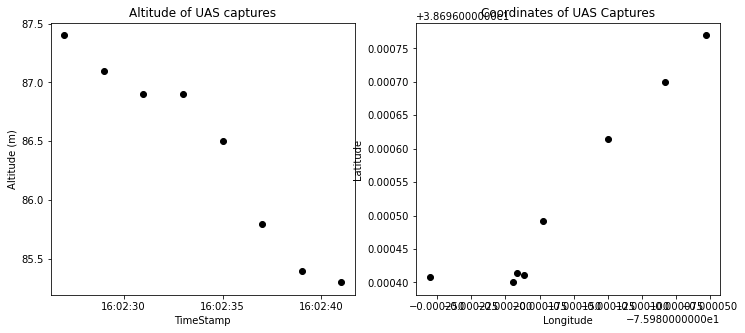

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#plot altitude
ax[0].scatter(rrs_img_metadata['DateTimeStamp'].values, rrs_img_metadata['Altitude'].values, color='black')
# ax[0].set_xticks(rotation=60)
ax[0].set_title("Altitude of UAS captures")
ax[0].set_xlabel("TimeStamp")
ax[0].set_ylabel("Altitude (m)")

#plot lat, lon
ax[1].scatter(rrs_img_metadata['Longitude'].values, rrs_img_metadata['Latitude'].values, color='black')
ax[1].set_title("Coordinates of UAS Captures")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

array([0.00776422, 0.01140823, 0.0131561 , 0.01477601, 0.00575559],
      dtype=float32)

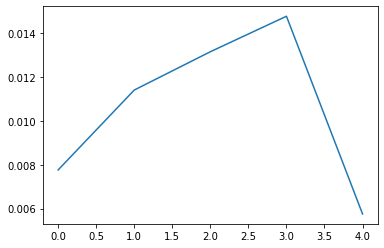

In [21]:
plt.plot(np.nanmean(rrs_imgs[0],axis=(1,2)))

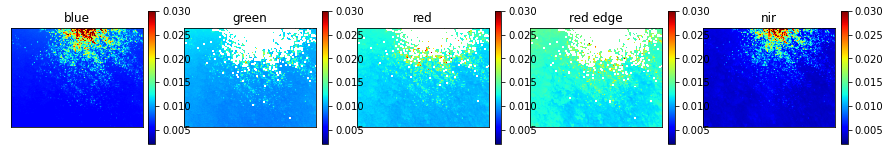

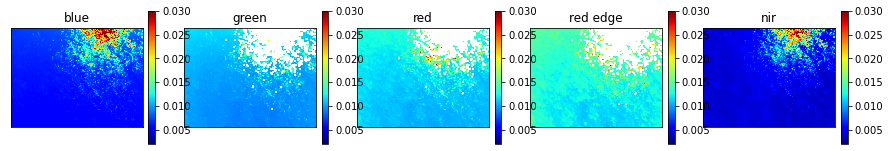

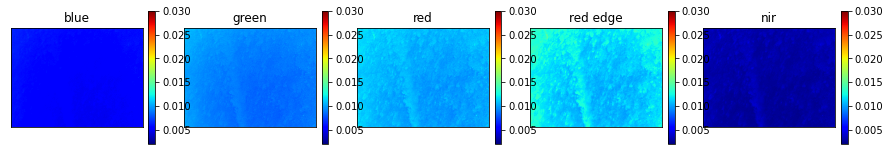

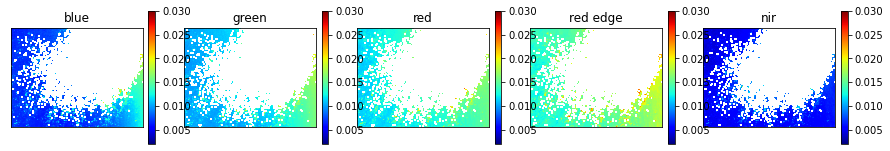

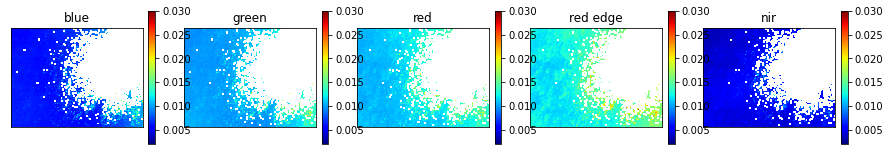

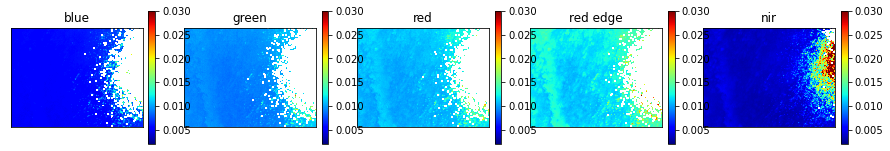

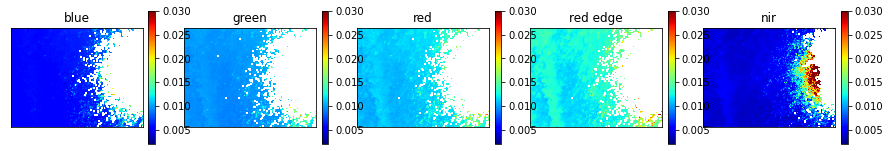

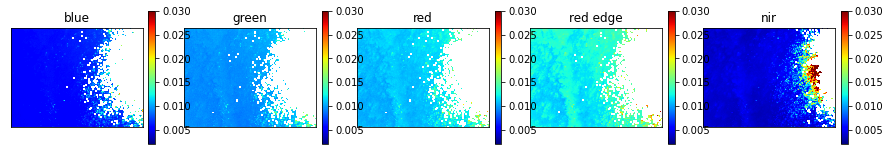

In [15]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(8):
    fig, ax = plt.subplots(1,5, figsize=(15,4))

    for i in range(5):
        im = ax[i].imshow(rrs_imgs[j,i],cmap='jet', vmin=0.002, vmax=0.03)
        fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    plt.show()

### Want to convert this to chlorophyll-a?

You can use the typical NASA algorithm, the OC Index (better for oligotrophic waters), or customize your own:

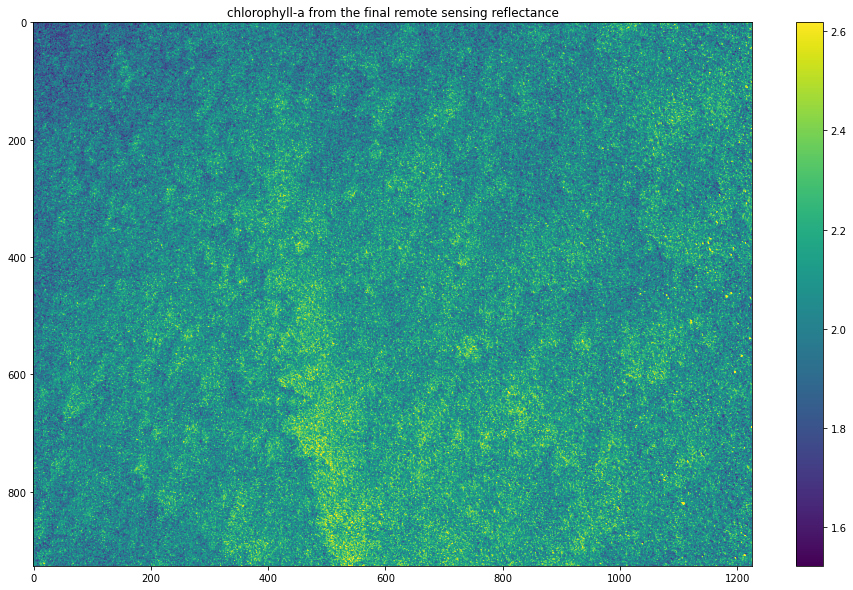

In [16]:
chla_img = vec_chla_img(rrs_imgs[2,1], rrs_imgs[2,2])

fig, ax = plt.subplots(1, figsize=(20,10))

im = ax.imshow(chla_img,cmap='viridis', 
               vmin=np.nanmedian(chla_img)-np.std(chla_img)*3, vmax=np.nanmedian(chla_img)+np.std(chla_img)*3)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('chlorophyll-a from the final remote sensing reflectance')
plt.show()

## Step by step workflow

Now typically you may want to customize your workflow a bit or test different approaches and visualizr it along the way. You can do that with a workflow like this:

### Process the Images to Reflectance
From https://support.micasense.com/hc/en-us/articles/360025336894-Using-Panels-and-or-DLS-in-Post-Processing

In the case of a clear, sunny day, we recommend using only the calibration panels. Light sensor data will not be as effective and so should generally not be used in this case.

Light sensor data is most effective in overcast, completely cloudy conditions. In this case, we would recommend using both light sensor and panel data for calibration.

In [9]:
surface_dir = os.path.join(project_path, 'flight')
surface_dir

'data/test/flight'

#### first output the surface imagery